In [11]:
import networkx as nx
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
df = pd.read_csv("space_data.tsv", sep = "\t")
df.head()

,source,target,depth
0,space exploration,discovery and exploration of the solar system,1
1,space exploration,in-space propulsion technologies,1
2,space exploration,robotic spacecraft,1
3,space exploration,timeline of planetary exploration,1
4,space exploration,landings on other planets,1


In [13]:
G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.Graph())

In [14]:
def sampleByWeight(G, v, t, p, q):
    nbrs = list(G.neighbors(v))
    if len(nbrs) == 0:
        return False
    weights = [1] * len(nbrs)
    for i, x in enumerate(nbrs):
        if t == x:
            weights[i] = 1 / p
        elif not G.has_edge(t, x):
            weights[i] = 1 / q
    return random.choices(nbrs, weights=weights, k=1)[0]


def walkOneTime(G, start_node, walk_length, p, q):
    walk = [start_node]  # 起始节点
    for _ in range(walk_length):
        cur_node = walk[-1]
        nbrs = list(G.neighbors(cur_node))
        if len(nbrs) > 0:
            if len(walk) == 1:
                walk.append(random.choice(nbrs))
            else:
                prev = walk[-2]
                v = sampleByWeight(G, cur_node, prev, p, q)
                if not v:
                    break
                walk.append(v)
        else:
            break
    return walk

def getNode2vecWalkSeqs(G, p, q, walk_length, num_walks):
    """get sequences

    Args:
        G (_Graph_): _Graph_
        walk_length (_int_): _每个序列的长度_
        num_walks (_int_): _序列的个数_
    """
    seqs = []
    for _ in tqdm(range(num_walks)):
        start_node = np.random.choice(G.nodes)
        w = walkOneTime(G, start_node, walk_length, p, q)
        seqs.append(w)
    return seqs

In [16]:
p = 0.5
q = 1.5
walks = getNode2vecWalkSeqs(G, p, q, 10, 10000)

100%|██████████| 10000/10000 [00:04<00:00, 2425.49it/s]


In [17]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [18]:
# train word2vec model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(walks, progress_per=2)

In [20]:
model.train(walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(2091907, 2200000)

In [21]:
# find top n similar nodes
model.wv.most_similar('astronaut training', topn=5)

[('micro-g environment', 0.9731670618057251),
 ('reduced-gravity aircraft', 0.9607090950012207),
 ('spaceflight osteopenia', 0.7832393050193787),
 ('microgravity university', 0.7644529938697815),
 ('space nursing', 0.739702582359314)]

In [25]:
terms = ['lunar escape systems','soviet moonshot', 'soyuz 7k-l1', 'moon landing',
        'space food', 'food systems on space exploration missions', 'meal, ready-to-eat',
        'space law', 'metalaw', 'moon treaty', 'legal aspects of computing',
        'astronaut training', 'reduced-gravity aircraft', 'space adaptation syndrome', 'micro-g environment']

In [22]:
def plot_nodes(word_list):
    X = model.wv[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    
    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    plt.show()

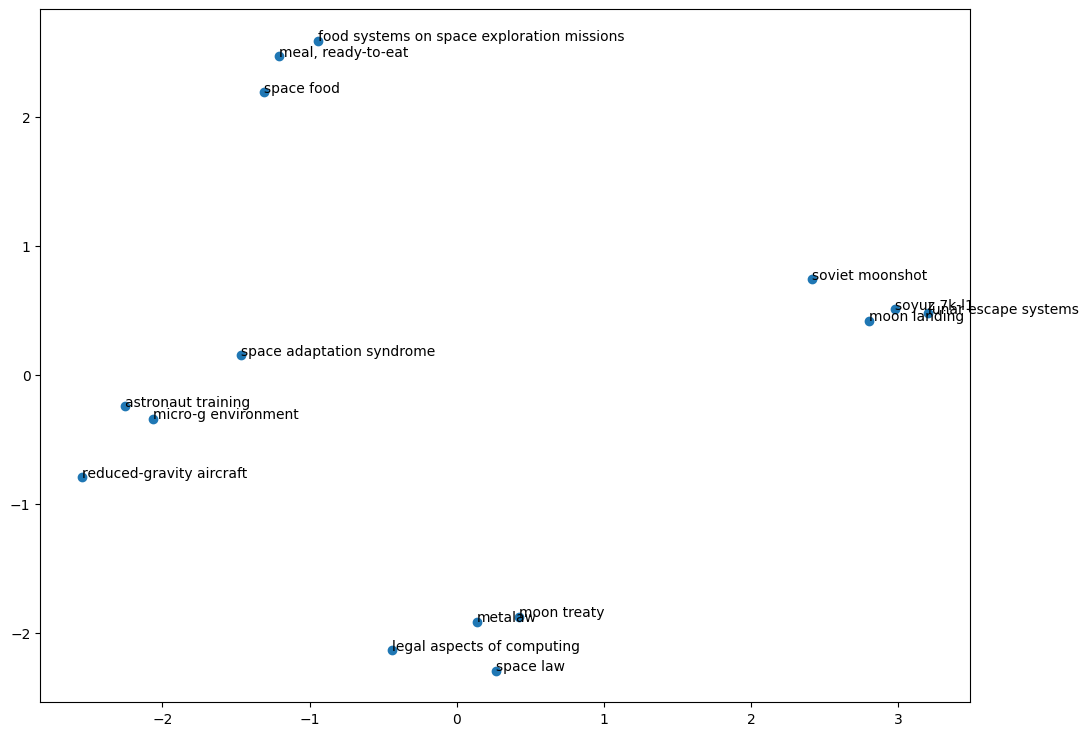

In [26]:
plot_nodes(terms)